In [86]:
import src.bloch_hamiltonian as blc
import src.disclination as disc

import numpy as np
from numpy import pi

import scipy as sp
import cupy as cp

from tqdm import tqdm

import matplotlib.pyplot as plt

# Define Pauli and Gamma matrices for convenience
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

gamma_1 = np.kron(sigma_x, sigma_z)
gamma_2 = np.kron(-sigma_y, sigma_0)
gamma_3 = np.kron(sigma_z, sigma_0)
gamma_4 = np.kron(sigma_x, sigma_x)
gamma_5 = np.kron(sigma_x, sigma_y)

norb = 4

In [133]:
# Real space in z Hamiltonian with a CDW potential added in

def z_ham(kx, ky, nz, q, delta, phi, params, **kwargs):
    h0, hz = blc.z_bloch_hamiltonian((kx, ky), *params)
    
    norb = h0.shape[0]

    hop_z = np.diag(np.ones(nz - 1), -1)

    ham = np.kron(np.identity(nz), h0)

    ham += np.kron(hop_z, hz)
    ham += np.kron(hop_z, hz).conj().T

    if 'pbc' in kwargs:
        if kwargs['pbc']:
            ham[0:norb, -norb:] += hz
            ham[-norb:, 0:norb] += hz.conj().T

    for ii in range(nz):
        ham[norb * ii:norb * (ii + 1), norb * ii:norb * (ii + 1)] += 2 * delta * np.cos(q * ii + phi) * gamma_3

    return ham

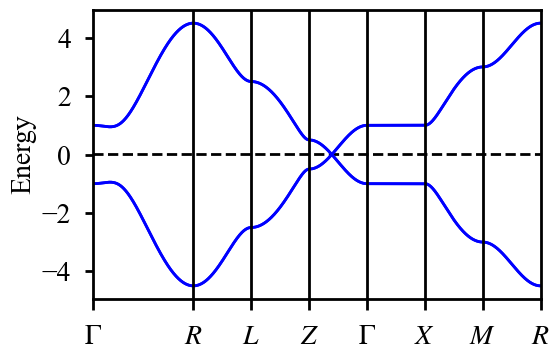

In [134]:
# Choose parameters and plot the band structure

nk = 50
nz = 100

k_ax = np.linspace(0, pi, nk + 1)[:-1]

m0 = 1.0
bxy = 1.0
bz = 0.75
g1 = 0.0
g2 = 0.0

params = (m0, bxy, bz, g1, g2)

c4_masses = (0.0, 0.0)

blc.plot_band_structure(0.01, *params, c4_masses=c4_masses, save=False)

q = np.arccos(1 - m0 / bz)

delta = 2.0
phi = 0.0

In [135]:
# Use a numerical optimizer to find the minimum direct gap in the BZ

def gap_func(x, *args):
    kx, ky = x

    ham = cp.asarray(z_ham(kx, ky, nz, q, delta, phi, params))

    u = cp.asnumpy(cp.linalg.eigvalsh(ham))

    return u[norb // 2 * nz] - u[norb // 2 * nz - 1]

res = sp.optimize.minimize(gap_func, (0.0, 0.0), method='Powell', bounds=((0, pi), (0, pi)))

print(f'Min gap location: (kx, ky) = ({res.x[0]:.2f}, {res.x[1]:.2f})')
print(f'Min gap value: {res.fun:.2g} eV')

Min gap location: (kx, ky) = (0.00, 0.00)
Min gap value: 0.15 eV


In [136]:
# Calculate the spectrum on a dense grid in one quadrant of the BZ

u = np.zeros((norb * nz, nk, nk))

for ii in tqdm(range(nk)):
    for jj in range(nk):
        ham = cp.asarray(z_ham(k_ax[ii], k_ax[jj], nz, q, delta, phi, params))
        u[:, ii, jj] = cp.asnumpy(cp.linalg.eigvalsh(ham))

 18%|█▊        | 9/50 [00:09<00:44,  1.08s/it]

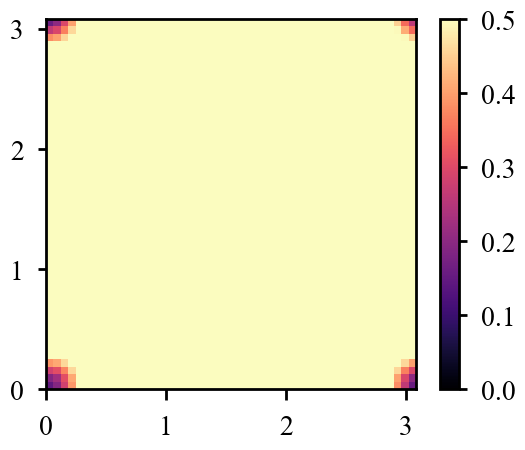

In [ ]:
# Plot the gap over a quadrant of the BZ

data = u[norb // 2 * nz] - u[norb // 2 * nz - 1]
plt.imshow(data.T, origin='lower', cmap='magma', vmin=0.0, vmax=0.5, extent=((0, k_ax[-1], 0, k_ax[-1])))
plt.colorbar()
plt.show()